#Importing necessary libraries

In [1]:
import random
import pandas as pd

#Generating synthetic email data

In [2]:
email_templates = {
    "Meeting Request": [
        {"subject": "Meeting about {topic}",
         "body": "Can we meet on {day} to discuss {topic}? Regards, {name}"},
        {"subject": "Schedule meeting: {topic}",
         "body": "I’d like to schedule a meeting with you about {topic} on {day}. Thanks, {name}"},
        {"subject": "Confirm availability",
         "body": "Please confirm your availability for a {topic} meeting this {time}. Best, {name}"}
    ],
    "Follow Up": [
        {"subject": "Follow up: {topic}",
         "body": "Just following up on our conversation about {topic}. Regards, {name}"},
        {"subject": "Review request",
         "body": "Have you had a chance to review the {topic} document? Thanks, {name}"},
        {"subject": "Checking status",
         "body": "Checking in on the status of {topic} from our last chat. – {name}"}
    ],
    "Leave Request": [
        {"subject": "Leave request for {day}",
         "body": "I would like to request leave on {day}. Please approve. – {name}"},
        {"subject": "Leave approval needed",
         "body": "Please approve my leave request for {day}. Regards, {name}"},
        {"subject": "Leave application",
         "body": "Could I take leave for {day}? Thank you, {name}"}
    ],
    "Complaint": [
        {"subject": "Complaint: {issue}",
         "body": "I am dissatisfied with the {issue}. This needs to be addressed. – {name}"},
        {"subject": "Urgent issue: {issue}",
         "body": "The {issue} needs urgent attention. Regards, {name}"},
        {"subject": "Formal complaint",
         "body": "This is a formal complaint regarding {issue}. Please advise. – {name}"}
    ],
    "Information Request": [
        {"subject": "Request: {topic}",
         "body": "Could you provide me with the details about {topic}? Thanks, {name}"},
        {"subject": "Info needed",
         "body": "Please share the information on {topic}. Regards, {name}"},
        {"subject": "Clarification request",
         "body": "I need more clarity regarding {topic}. Thanks, {name}"}
    ],
    "Others": [
        {"subject": "Greetings",
         "body": "Hope you’re doing well. Best wishes, {name}"},
        {"subject": "Thanks!",
         "body": "Just wanted to say thank you. Regards, {name}"},
        {"subject": "Nice to see you",
         "body": "It was great seeing you yesterday. Take care, {name}"}
    ]
}

#Substitution lists for the synthetic data
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "next week"]
topics = ["budget", "project plan", "marketing strategy", "team performance", "policy update"]
issues = ["delayed response", "system downtime", "incorrect billing", "service quality"]
names = ["Alice", "Bob", "Charlie", "David", "Eve","Alex", "Taylor", "Jordan", "Casey", "Morgan"]
time= ["morning", "afternoon", "evening", "11AM", "1PM", "4PM", "8AM", "ASAP"]

#Generating the emails
def generate_email(intent, template):
    return {
        "intent": intent,
        "subject": template["subject"].format(
            day=random.choice(days),
            topic=random.choice(topics),
            issue=random.choice(issues),
            name=random.choice(names),
            time=random.choice(time)
        ),
        "body": template["body"].format(
            day=random.choice(days),
            topic=random.choice(topics),
            issue=random.choice(issues),
            name=random.choice(names),
            time=random.choice(time)
        )
    }

#Generating the dataset
emails = []
for intent, templates in email_templates.items():
    for i in range(200):  # 200 per category × 6 = 1200 emails
        template = random.choice(templates)
        text = generate_email(intent, template)
        emails.append({"intent": intent, "email": text})

#Converting the dataset into a DataFrame
df = pd.DataFrame(emails)
print(df.head(10))
print(f"\nTotal emails generated: {len(df)}")

# --- Step 7: Save as CSV (optional) ---
df.to_csv("synthetic_emails.csv", index=False)

            intent                                              email
0  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Meet...
1  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...
2  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...
3  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...
4  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Sche...
5  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Sche...
6  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...
7  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...
8  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Sche...
9  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Meet...

Total emails generated: 1200


#Data Preprocessing

In [3]:
# Combining subject and body for the input text
df['input'] = 'SUBJECT: ' + df['email'].apply(lambda x: x['subject']) + ' BODY: ' + df['email'].apply(lambda x: x['body'])

# Converting to "Hugging Face" Dataset format
from datasets import Dataset
dataset = Dataset.from_pandas(df)

# Creating a label
label_list = sorted(df['intent'].unique().tolist())
label_to_id = {label: i for i, label in enumerate(label_list)}

#Sentiment Analysis

In [4]:
!pip install --q transformers pandas
from transformers import pipeline

df = pd.read_csv("synthetic_emails.csv")

# Extracting subject and body from the 'email' column
df['subject'] = df['email'].apply(lambda x: eval(x)['subject'])
df['body'] = df['email'].apply(lambda x: eval(x)['body'])


# Sentiment analysis pipeline
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english"
)

# Defining "urgency"/ "top priority" keywords
urgency_keywords = ["urgent", "ASAP", "immediately", "important",
                    "request", "complaint", "deadline", "attention"]

def auto_label(row):
    text = f"{row['subject']} {row['body']}".lower()

    # 1: Keyword check
    if any(keyword in text for keyword in urgency_keywords):
        return 1

    # 2: Sentiment check
    sentiment = sentiment_analyzer(text[:512])[0]  # truncate to 512 tokens for BERT
    if sentiment["label"] == "NEGATIVE" and sentiment["score"] > 0.8:
        return 1

    # Otherwise not urgent
    return 0

# Labeling the urgency column
df["urgency"] = df.apply(auto_label, axis=1)

# Checking the distribution
print(df["urgency"].value_counts())
print(df.head())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


urgency
0    605
1    595
Name: count, dtype: int64
            intent                                              email  \
0  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Meet...   
1  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...   
2  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...   
3  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Conf...   
4  Meeting Request  {'intent': 'Meeting Request', 'subject': 'Sche...   

                              subject  \
0          Meeting about project plan   
1                Confirm availability   
2                Confirm availability   
3                Confirm availability   
4  Schedule meeting: team performance   

                                                body  urgency  
0  Can we meet on Thursday to discuss marketing s...        0  
1  Please confirm your availability for a project...        0  
2  Please confirm your availability for a budget ...        0  
3  Ple

In [5]:
# Saving the merged dataset
df.to_csv("Merged_emails.csv", index=False)
print("Merged dataset saved with urgency labels.")

Merged dataset saved with urgency labels.


#Balancing the Dataset using Oversampling

In [6]:
from sklearn.utils import resample

# Separating the majority and minority classes
urgent_df = df[df["urgency"] == 1]
not_urgent_df = df[df["urgency"] == 0]

# Finding class counts
urgent_count = len(urgent_df)
not_urgent_count = len(not_urgent_df)

print("Before balancing:")
print("Urgent:", urgent_count, "Not urgent:", not_urgent_count)

# Oversampling the minority class
if urgent_count < not_urgent_count:
    urgent_df_balanced = resample(urgent_df,
                                  replace=True,
                                  n_samples=not_urgent_count,
                                  random_state=42)
    not_urgent_df_balanced = not_urgent_df
else:
    not_urgent_df_balanced = resample(not_urgent_df,
                                      replace=True,
                                      n_samples=urgent_count,
                                      random_state=42)
    urgent_df_balanced = urgent_df

# Combining it back into a single dataset
balanced_df = pd.concat([urgent_df_balanced, not_urgent_df_balanced])

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nAfter balancing:")
print(balanced_df["urgency"].value_counts())

Before balancing:
Urgent: 595 Not urgent: 605

After balancing:
urgency
1    605
0    605
Name: count, dtype: int64


In [7]:
balanced_df.to_csv("balanced_merged_emails.csv", index=False)
print("Balanced dataset saved!")

Balanced dataset saved!


#Model Training: DistilBERT

In [8]:
!pip install --q transformers datasets scikit-learn evaluate

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import evaluate

df = pd.read_csv("balanced_merged_emails.csv")

#Labeling the dataset
labels = df["urgency"].tolist()
texts = (df["subject"] + " " + df["body"]).tolist()

# Splitting the dataset into train/val
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.2, random_state=42)

train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df = pd.DataFrame({"text": X_val, "label": y_val})

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)


# Tokenizer & Model (NLP Subset)
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

num_labels = len(set(labels))

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

#Evaluation Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)
    f1_score = f1.compute(predictions=preds, references=p.label_ids, average="weighted")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

#Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

#Training the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


print("Starting training...")
trainer.train()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/968 [00:00<?, ? examples/s]

Map:   0%|          | 0/242 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-184959692.py:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.546675,0.933884,0.933762
2,0.528600,0.079628,0.979339,0.979351
3,0.528600,0.108663,0.979339,0.979351


TrainOutput(global_step=183, training_loss=0.3054657477498706, metrics={'train_runtime': 169.8083, 'train_samples_per_second': 17.102, 'train_steps_per_second': 1.078, 'total_flos': 384685325697024.0, 'train_loss': 0.3054657477498706, 'epoch': 3.0})

#Checking for overfitting/underfitting

In [9]:
# Evaluating on validation set
val_results = trainer.evaluate()
print("\nValidation Results:", val_results)

# Evaluating on training set
train_results = trainer.evaluate(train_dataset)
print("\nTraining Results:", train_results)



Validation Results: {'eval_loss': 0.07962796092033386, 'eval_accuracy': 0.9793388429752066, 'eval_f1': 0.9793512011824332, 'eval_runtime': 3.9678, 'eval_samples_per_second': 60.992, 'eval_steps_per_second': 4.033, 'epoch': 3.0}

Training Results: {'eval_loss': 0.03824355825781822, 'eval_accuracy': 0.9927685950413223, 'eval_f1': 0.9927675682292676, 'eval_runtime': 16.7717, 'eval_samples_per_second': 57.716, 'eval_steps_per_second': 3.637, 'epoch': 3.0}


###Interpretation of results
> Training and Validation accuracy are close thus the model seems to be a **Good fit**.

In [10]:
# Save fine-tuned model + tokenizer
trainer.save_model("./nlp_email_model")
tokenizer.save_pretrained("./nlp_email_model")

('./nlp_email_model/tokenizer_config.json',
 './nlp_email_model/special_tokens_map.json',
 './nlp_email_model/vocab.txt',
 './nlp_email_model/added_tokens.json',
 './nlp_email_model/tokenizer.json')

#ML Component 2: Stress Classifier

#Importing Libraries

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Loading the Dataset

In [12]:
stress = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")

# Data Exploration

In [13]:
# Display the first 5 rows of the dataset
stress.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [14]:
# Display the data types, non-null counts, and memory usage.
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [15]:
# Checking the null values
stress.isnull().sum()

,0
Person ID,0
Gender,0
Age,0
Occupation,0
Sleep Duration,0
Quality of Sleep,0
Physical Activity Level,0
Stress Level,0
BMI Category,0
Blood Pressure,0


In [16]:
rows = stress[pd.isna(stress["Sleep Disorder"])]
rows

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,342,Female,56,Doctor,8.2,9,90,3,Normal Weight,118/75,65,10000,NaN
342,343,Female,56,Doctor,8.2,9,90,3,Normal Weight,118/75,65,10000,NaN
343,344,Female,57,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,NaN
358,359,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,NaN


In [17]:
stress = stress.fillna("Nothing")
stress.head(1)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,Nothing


Also, we can observe that in the "BMI Category" column, the term "Normal" and "Normal Weight" have same meaning. Hence, we replace the value with "Normal" for consistency.


In [18]:
stress["BMI Category"] = stress["BMI Category"].replace("Normal Weight", "Normal")

In [19]:
stress['Stress Level'].value_counts()

,count
Stress Level,
3,71
8,70
4,70
5,67
7,50
6,46


**Label Encoding**

The dataset includes categorical data, such as "Occupation", "BMI Category", and "Sleep Disorder Columns".
We perform 'Label Encoding' to convert these categorical values into numerical data.

Label Encoding assigns a unique numerical label to each category in a categorical feature.
Algorithms used for computation, including those employed in machine learning, typically require numeric inputs for effective processing and analysis.

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [21]:
label_encoder=LabelEncoder()

In [22]:
cat_cols=['Gender','Occupation','BMI Category','Sleep Disorder']
for col in cat_cols:
    stress[col] = label_encoder.fit_transform(stress[col])

stress.tail(2)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
372,373,0,59,5,8.1,9,75,3,2,140/95,68,7000,2
373,374,0,59,5,8.1,9,75,3,2,140/95,68,7000,2


In the "Blood Pressure" column, the entries are in '140/95' format. This might lead to further inconsistencies, hence we split the blood pressure into two unique columns. i.e. 'Systolic BP' and 'Diastolic BP'.

In [23]:
stress[['Systolic BP', 'Diastolic BP']] = stress['Blood Pressure'].str.split('/', expand=True)

# Convert the new columns to numeric type
stress[['Systolic BP', 'Diastolic BP']] = stress[['Systolic BP', 'Diastolic BP']].apply(pd.to_numeric)

# Drop the original 'Blood Pressure' column
stress = stress.drop('Blood Pressure', axis=1)

stress.head(1)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP
0,1,1,27,9,6.1,6,42,6,2,77,4200,1,126,83


The 'Person ID' column does not contain relevant information as all the values are unique identifiers, so we drop it.

In [24]:
stress.drop('Person ID', axis=1, inplace=True)

Shifting the column "Stress Level" to the last position of the dataset for easier access.

In [25]:
stress_level_index = stress.columns.get_loc('Stress Level')

columns = list(stress.columns[:stress_level_index]) + list(stress.columns[stress_level_index+1:]) + ['Stress Level']

stress = stress[columns]
stress.tail(1)

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Systolic BP,Diastolic BP,Stress Level
373,0,59,5,8.1,9,75,2,68,7000,2,140,95,3


# Data Visualization

In [26]:
fig = px.violin(stress, x='Heart Rate', y='Stress Level', title='Stress Distribution by Heart Rate', color_discrete_sequence=['#FFD700'])
fig.update_layout(xaxis_title='Heart Rate', yaxis_title='Stress Level',width=600,height=500)
fig.show()

# Correlation Analysis

<function matplotlib.pyplot.show(close=None, block=None)>

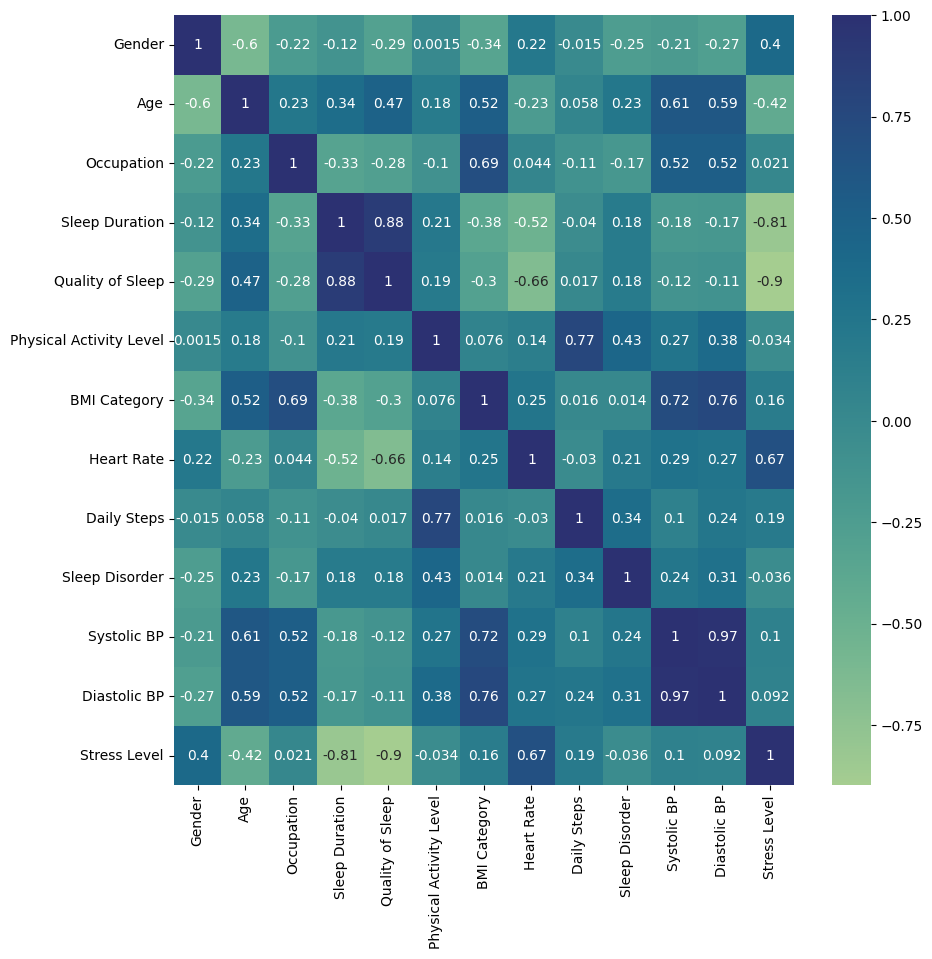

In [27]:
plt.figure(figsize = (10, 10))
sns.heatmap(stress.corr(), cmap = 'crest', annot = True)
plt.show

# Correlation Analysis Filtered
> Filtered strongly positively correlated variables out to avoid Multicollinearity

<function matplotlib.pyplot.show(close=None, block=None)>

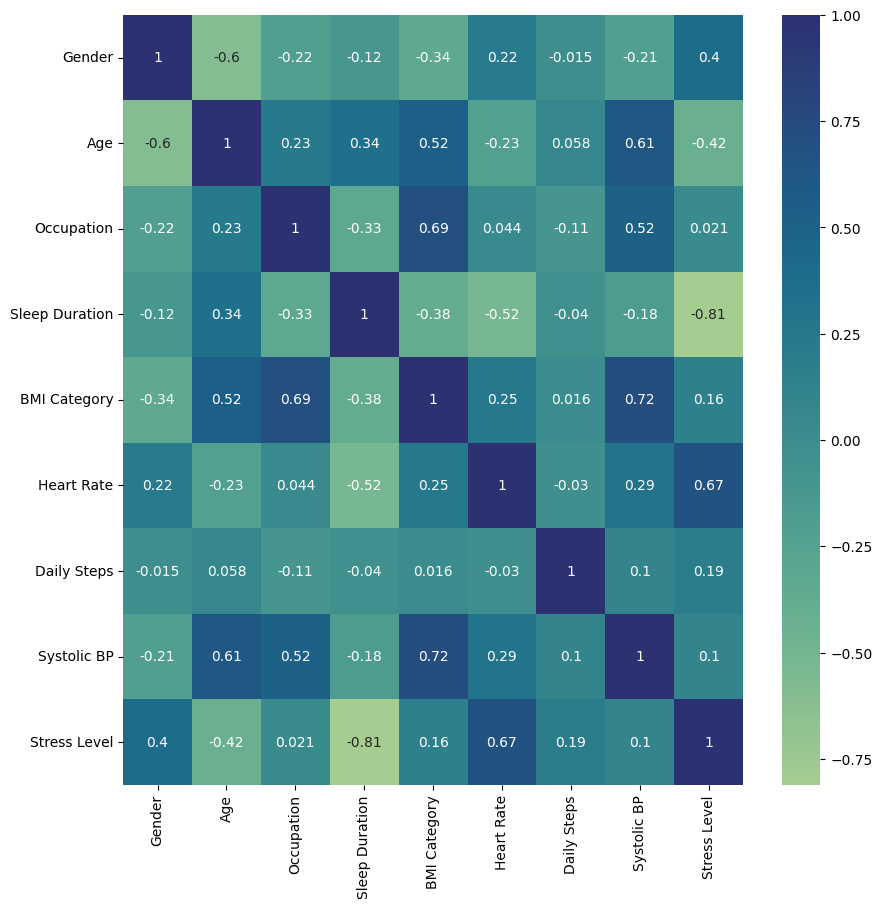

In [28]:
stress.drop('Sleep Disorder', axis=1, inplace=True)
stress.drop('Physical Activity Level', axis=1, inplace=True)
stress.drop('Diastolic BP', axis=1, inplace=True)
stress.drop('Quality of Sleep', axis=1, inplace=True)

#Plot the heatmap
plt.figure(figsize = (10, 10))
sns.heatmap(stress.corr(), cmap = 'crest', annot = True)
plt.show

# Importing Modules & Packages for ML

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Data Preparation

In [30]:
# Split the data into features (X) and the target variable (y)
X = stress.drop(['Stress Level'], axis=1)
y = stress['Stress Level']

In [31]:
# Split the data into training and testing sets (80% training, 20% testing)
X_Train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the training and testing sets
print("X_train shape:", X_Train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (299, 8)
y_train shape: (299,)
X_test shape: (75, 8)
y_test shape: (75,)


In [32]:
X_Train

,Gender,Age,Occupation,Sleep Duration,BMI Category,Heart Rate,Daily Steps,Systolic BP
192,1,43,7,6.5,2,72,6000,130
75,1,33,1,6.0,0,72,5000,125
84,1,35,9,7.5,0,70,8000,120
362,0,59,5,8.2,2,68,7000,140
16,0,29,5,6.5,0,80,4000,132
...,...,...,...,...,...,...,...,...
71,1,33,1,6.1,0,72,5000,125
106,0,37,5,6.1,2,77,4200,126
270,0,49,5,6.1,2,75,10000,140
348,0,57,5,8.2,2,68,7000,140


# A. Logistic Regression

In [33]:
# Instantiating the object and fitting
model = LogisticRegression()
model.fit(X_Train, y_train)

# Predicting the values
predicted = model.predict(X_test)

# Confusion matrix
conf = confusion_matrix(y_test, predicted)
print("Confusion Matrix : \n", conf)

cr = classification_report(y_test, predicted)
print("Classification Report:\n", cr)

# Printing the test accuracy
print("The test accuracy of Logistic Regression is : ", accuracy_score(y_test, predicted) * 100, "%")

Confusion Matrix : 
 [[12  0  0  0  0  0]
 [ 0  4  0  0  0  6]
 [ 0  1 11  0  2  0]
 [ 0  1  0  8  1  0]
 [ 1 10  0  0  1  0]
 [ 0  9  5  1  2  0]]
Classification Report:
               precision    recall  f1-score   support

           3       0.92      1.00      0.96        12
           4       0.16      0.40      0.23        10
           5       0.69      0.79      0.73        14
           6       0.89      0.80      0.84        10
           7       0.17      0.08      0.11        12
           8       0.00      0.00      0.00        17

    accuracy                           0.48        75
   macro avg       0.47      0.51      0.48        75
weighted avg       0.44      0.48      0.45        75

The test accuracy of Logistic Regression is :  48.0 %


# B. Naive Bayes

In [34]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_Train,y_train)

GaussianNB()

In [35]:
naive_bayes.score(X_test,y_test)

0.9066666666666666

In [36]:
y_predict = naive_bayes.predict(X_test)

In [37]:
matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0  8  1  1  0  0]
 [ 1  0 12  0  1  0]
 [ 0  1  0  8  0  1]
 [ 0  0  0  0 12  0]
 [ 0  0  0  1  0 16]]


In [38]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           3       0.92      1.00      0.96        12
           4       0.89      0.80      0.84        10
           5       0.92      0.86      0.89        14
           6       0.80      0.80      0.80        10
           7       0.92      1.00      0.96        12
           8       0.94      0.94      0.94        17

    accuracy                           0.91        75
   macro avg       0.90      0.90      0.90        75
weighted avg       0.91      0.91      0.91        75



# C. Support Vector Mechanism

In [39]:
svm_classifier = svm.SVC(kernel='linear')

In [40]:
svm_classifier.fit(X_Train, y_train)

y_pred = svm_classifier.predict(X_test)


In [41]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9066666666666666


In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 11  1  2  0]
 [ 0  1  0  9  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  2 15]]
Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        12
           4       0.91      1.00      0.95        10
           5       1.00      0.79      0.88        14
           6       0.82      0.90      0.86        10
           7       0.73      0.92      0.81        12
           8       1.00      0.88      0.94        17

    accuracy                           0.91        75
   macro avg       0.91      0.91      0.91        75
weighted avg       0.92      0.91      0.91        75



# D. KNN Classifier


In [43]:
knn = KNeighborsClassifier()
knn.fit(X_Train, y_train)

KNeighborsClassifier()

In [44]:
knn.score(X_test,y_test)


0.9333333333333333

In [45]:
y_predict = knn.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 13  1  0  0]
 [ 0  1  0  8  1  0]
 [ 0  0  0  0 12  0]
 [ 0  0  2  0  0 15]]


In [46]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        12
           4       0.91      1.00      0.95        10
           5       0.87      0.93      0.90        14
           6       0.89      0.80      0.84        10
           7       0.92      1.00      0.96        12
           8       1.00      0.88      0.94        17

    accuracy                           0.93        75
   macro avg       0.93      0.94      0.93        75
weighted avg       0.94      0.93      0.93        75



# E. Random Forest Classifier


In [47]:
random_forest = RandomForestClassifier(n_estimators=13)
random_forest.fit(X_Train,y_train)

RandomForestClassifier(n_estimators=13)

In [48]:
random_forest.score(X_test,y_test)

0.96

In [49]:
y_predict = random_forest.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 14  0  0  0]
 [ 0  1  0  8  0  1]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  1 16]]


In [50]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        12
           4       0.91      1.00      0.95        10
           5       1.00      1.00      1.00        14
           6       1.00      0.80      0.89        10
           7       0.92      1.00      0.96        12
           8       0.94      0.94      0.94        17

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75



# F. Decision Tree

In [51]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_Train,y_train)

DecisionTreeClassifier()

In [52]:
decision_tree.score(X_test,y_test)

0.9733333333333334

In [53]:
y_predict = decision_tree.predict(X_test)

matrix = confusion_matrix(y_test, y_predict)

print("Confusion Matrix:")
print(matrix)

Confusion Matrix:
[[12  0  0  0  0  0]
 [ 0 10  0  0  0  0]
 [ 0  0 12  2  0  0]
 [ 0  0  0 10  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 17]]


In [54]:
report = classification_report(y_test, y_predict)

# Print the classification report
print("Classification Report:")
print(report)



Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        10
           5       1.00      0.86      0.92        14
           6       0.83      1.00      0.91        10
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        17

    accuracy                           0.97        75
   macro avg       0.97      0.98      0.97        75
weighted avg       0.98      0.97      0.97        75



In [55]:
model_names = ['Logistic Regression', 'Naive Bayes',  'SVM', 'KNN', 'Random Forest', 'Decision Tree']
accuracy_scores = [48, 91, 91, 93, 97, 97]

data = {'Model': model_names, 'Accuracy Score': accuracy_scores}

df = pd.DataFrame(data)

colors = px.colors.qualitative.Pastel

fig = px.bar(df, x='Model', y='Accuracy Score', text='Accuracy Score',
             title='Comparison of Model Accuracy', color='Model',
             color_discrete_map={model: color for model, color in zip(model_names, colors)})

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(width=700, height=600)

fig.show()

# Conclusion

The Random Forest Classifier and Decision Tree models emerged as the top performers, achieving good accuracy scores of 96% and 97%, respectively.
Logistic Regression showed notably lower performance at 48%.

Furthermore, it's important to acknowledge the impact of data size on model performance. With a relatively small dataset, the ability of models to generalise might be compromised, leading to variations in performance. However, fine-tuning model parameters and exploring ensemble methods further improve predictive accuracy.

In [56]:
# Save the trained Random Forest model
import pickle

with open("stress_random_forest.pkl", "wb") as f:
    pickle.dump(random_forest, f)

print("Random Forest model saved as stress_random_forest.pkl")

Random Forest model saved as stress_random_forest.pkl


#ML Component 3: Decision Engine

In [57]:
import numpy as np
import pickle
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

class DecisionEngine:
    def __init__(self, nlp_model_path, stress_model_path):
        # Store model paths
        self.nlp_model_path = nlp_model_path
        self.stress_model_path = stress_model_path

        # Load Stress classifier
        with open(stress_model_path, "rb") as f:
            self.stress_model = pickle.load(f)

        # Feature order (excluding Age, Gender, Occupation)
        self.feature_order = ["Sleep_Duration", "BMI_Category", "Heart_Rate", "Daily_Steps", "Systolic_BP"]

    def recommend_break(self, features):
        """Generate personalized break suggestion"""
        if features["Daily_Steps"] < 4000:
            return "Take a 10-minute walk to refresh your mind."
        elif features["Sleep_Duration"] < 6:
            return "Power down with a short rest or breathing exercise."
        elif features["Heart_Rate"] > 90:
            return "Try 5 minutes of mindfulness or meditation to calm down."
        else:
            return "Take a short coffee/tea break."

    def __call__(self, email_text, stress_features):
        # Load NLP model and tokenizer within the call method
        tokenizer = AutoTokenizer.from_pretrained(self.nlp_model_path)
        nlp_model = AutoModelForSequenceClassification.from_pretrained(self.nlp_model_path)

        # NLP intent prediction
        tokens = tokenizer(email_text, padding=True, truncation=True, return_tensors="pt")
        outputs = nlp_model(**tokens)
        intent_id = int(outputs.logits.argmax(dim=1).item())
        intent_label = nlp_model.config.id2label[intent_id]

        # Stress level prediction
        stress_input = np.array([[stress_features[f] for f in self.feature_order]])
        stress_level = int(self.stress_model.predict(stress_input)[0])

        # Break suggestion
        break_suggestion = self.recommend_break(stress_features)

        # Final recommendation
        if "high" in intent_label.lower() and stress_level >= 7:
            recommendation = f"You seem stressed. {break_suggestion} Then tackle the high-priority task."
        elif "high" in intent_label.lower():
            recommendation = "You’re in a good state. Start working on this high-priority task."
        elif "reminder" in intent_label.lower() and stress_level >= 7:
            recommendation = f"Handle the reminder later. {break_suggestion}"
        else:
            recommendation = f"Intent: {intent_label}, Stress Level: {stress_level}. {break_suggestion}"

        return {
            "intent": intent_label,
            "stress_level": stress_level,
            "recommendation": recommendation
        }

engine = DecisionEngine(
    nlp_model_path="./nlp_email_model",
    stress_model_path="stress_random_forest.pkl"
)

with open("decision_engine.pkl", "wb") as f:
    pickle.dump(engine, f)

print("Decision Engine pickled as decision_engine.pkl")

Decision Engine pickled as decision_engine.pkl


In [58]:
#import pickle

# Load engine
#with open("decision_engine.pkl", "rb") as f:
    #engine = pickle.load(f)

# Example run
#sample_email = "Please submit the project report by tomorrow EOD."
#sample_features = {
    #"Sleep_Duration": 5,
    #"BMI_Category": 2,
    #"Heart_Rate": 95,
    #"Daily_Steps": 2500,
    #"Systolic_BP": 122
#}

#result = engine(sample_email, sample_features)
#print(result)
